In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

pd.set_option('display.max_columns', None)

/tmp/ipykernel_82155/2691490471.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [9]:
df = pd.read_csv('races.csv')
df = df[df.team1.str.startswith('Wild')]
df = df.replace('unknown', np.nan)
df.when = pd.to_datetime(df.when)
df.head(2)

,division,when,team1,team2,time_tot,win,hurdles,name1,start_chng1,time1,name2,start_chng2,time2,name3,start_chng3,time3,name4,start_chng4,time4,event,course_color
0,1,2023-04-22 10:11:57,WildRunners dreamers,WildRunners Maximini,17.01,L,25.0,Sunny,-0.24,4.21,Dixie,0.30,4.24,Alex,0.16,4.22,Hector,0.0,4.13,Hanácké škvarek (Heroltice),blue
1,1,2023-04-22 10:11:57,WildRunners Maximini,WildRunners dreamers,19.43,L,25.0,Brooke,-0.11,4.08,Rocky,1.29,5.15,Bella,0.23,4.52,Bree,0.0,4.28,Hanácké škvarek (Heroltice),red


In [92]:
df_run1 = df[['when', 'name1', 'start_chng1', 'time1']]
df_run2 = df[['when', 'name2', 'start_chng2', 'time2']]
df_run3 = df[['when', 'name3', 'start_chng3', 'time3']]
df_run4 = df[['when', 'name4', 'start_chng4', 'time4']]

col_names = ['when', 'name', 'start_chng', 'time']
df_run1.columns = col_names
df_run2.columns = col_names
df_run3.columns = col_names
df_run4.columns = col_names

df_run1 = df_run1.dropna()
df_run2 = df_run2.dropna()
df_run3 = df_run3.dropna()
df_run4 = df_run4.dropna()

df_runs_234 = pd.concat([df_run2, df_run3, df_run4], axis=0)

df_runs_all = pd.concat([df_run1, df_run2, df_run3, df_run4], axis=0)
df_runs_all['total_time'] = np.where(df_runs_all.start_chng >= 0, df_runs_all.time + df_runs_all.start_chng, None)
df_runs_all.shape

(4370, 5)

In [81]:
days = np.sort(df_runs_all.when.dt.date.unique())
print(days)

[datetime.date(2023, 4, 22) datetime.date(2023, 4, 23)
 datetime.date(2023, 5, 6) datetime.date(2023, 5, 7)
 datetime.date(2023, 5, 20) datetime.date(2023, 5, 21)
 datetime.date(2023, 6, 24) datetime.date(2023, 6, 25)
 datetime.date(2023, 7, 1) datetime.date(2023, 7, 2)
 datetime.date(2023, 7, 15) datetime.date(2023, 7, 16)
 datetime.date(2023, 7, 29) datetime.date(2023, 7, 30)
 datetime.date(2023, 9, 3) datetime.date(2023, 9, 4)
 datetime.date(2023, 9, 16) datetime.date(2023, 9, 17)
 datetime.date(2023, 10, 14) datetime.date(2023, 10, 15)]


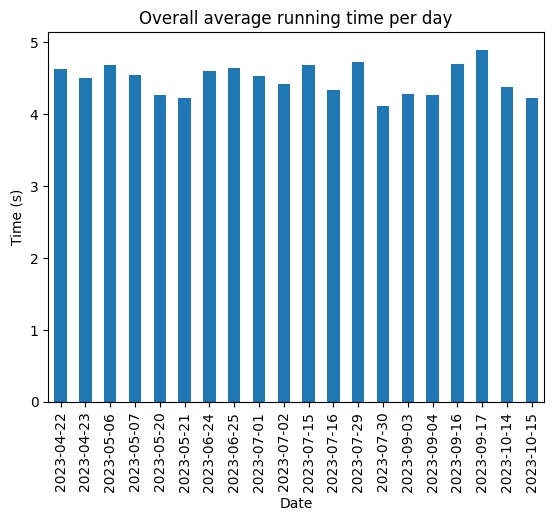

In [82]:
df_runs_all.groupby(df_runs_all.when.dt.date).time.mean().plot(kind='bar')
plt.xlabel('Date')
plt.ylabel('Time (s)')
plt.title('Overall average running time per day')
plt.show()

In [77]:
def most_runs(df, date):
    temp = df[df.when.dt.date == date]
    return temp.name.value_counts()[:7]

In [43]:
def fastest_runers(df, date):
    temp = df[df.when.dt.date == date]
    return temp.groupby('name').time.mean().sort_values()[:7]

In [93]:
def best_overall(df, date):
    temp = df[df.when.dt.date == date]
    temp = temp.dropna()
    return temp.groupby('name').total_time.mean().sort_values()[:7]

In [88]:
def fastest_starters(df, date):
    temp = df[df.when.dt.date == date]
    temp = temp[temp.start_chng >= 0]
    return temp.groupby('name').start_chng.mean().sort_values()[:7]

In [117]:
def good_starters(df, date):
    temp = df[df.when.dt.date == date]
    
    dogs = pd.DataFrame({
        'name': temp.name.unique(),
        'runs': 0,
        'good': 0,
        'wrong': 0
    })
    dogs = dogs.set_index('name')

    for _, row in temp.iterrows():
        when, name, start_chng, time, _ = row
        dogs.loc[name, 'runs'] += 1
        if start_chng < 0:
            dogs.loc[name, 'wrong'] += 1
        else:
            dogs.loc[name, 'good'] += 1

    dogs['wrong_ratio'] = dogs.wrong / dogs.runs * 100
    dogs = dogs[dogs.runs >= 5]

    return dogs.sort_values('wrong_ratio')[:7]

In [97]:
top_2_any_day = set()

for day in days:
    top_2_any_day.update(best_overall(df_runs_all, day)[:2].index)

top_2_any_day

{'Alfie',
 'Bree',
 'Brooke',
 'Cookies',
 'Enola',
 'Maggie',
 'Moon',
 'Pax',
 'Sunny',
 'Tyna'}

## Most running dogs per day

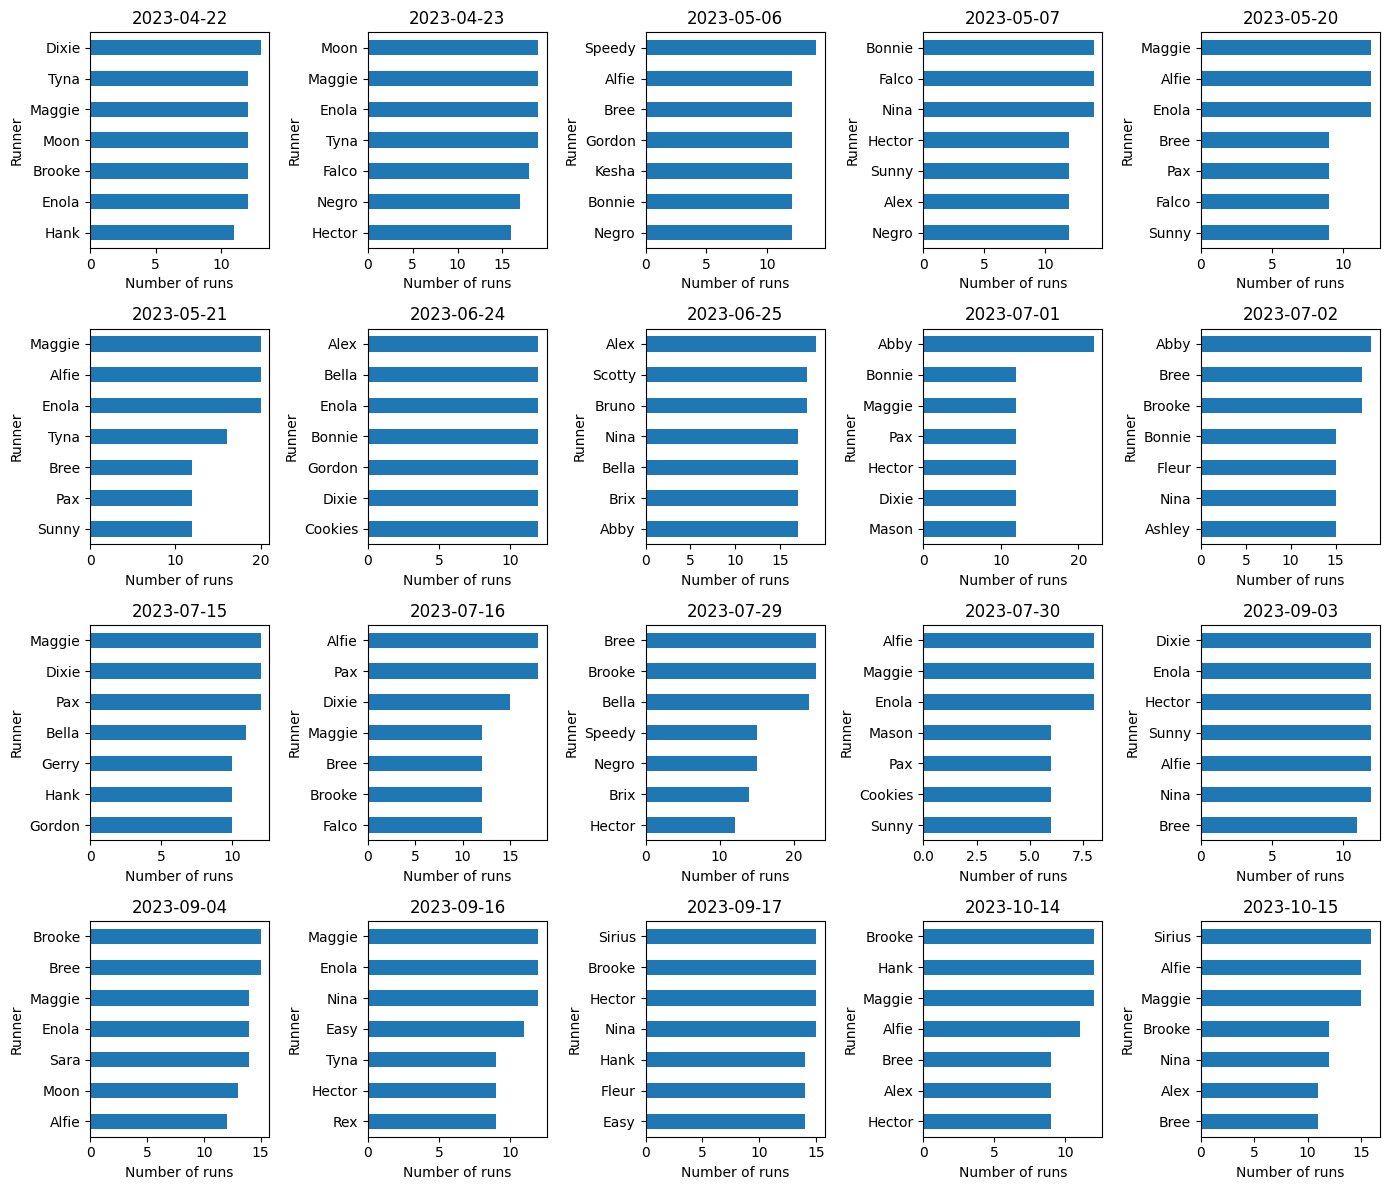

In [84]:
fig, axs = plt.subplots(4, 5, figsize=(14, 12))

for i, day in enumerate(days):
    ax = axs[i//5, i%5]
    most_runs(df_runs_all, day).sort_values().plot(kind='barh', ax=ax)
    ax.set_title(day)
    ax.set_ylabel('Runner')
    ax.set_xlabel('Number of runs')

plt.tight_layout()
plt.show()


## Best total times per day

Showing the top seven dogs in terms of average total time (run time + start time or change time)

Only the runs with correct start / change are taken into account

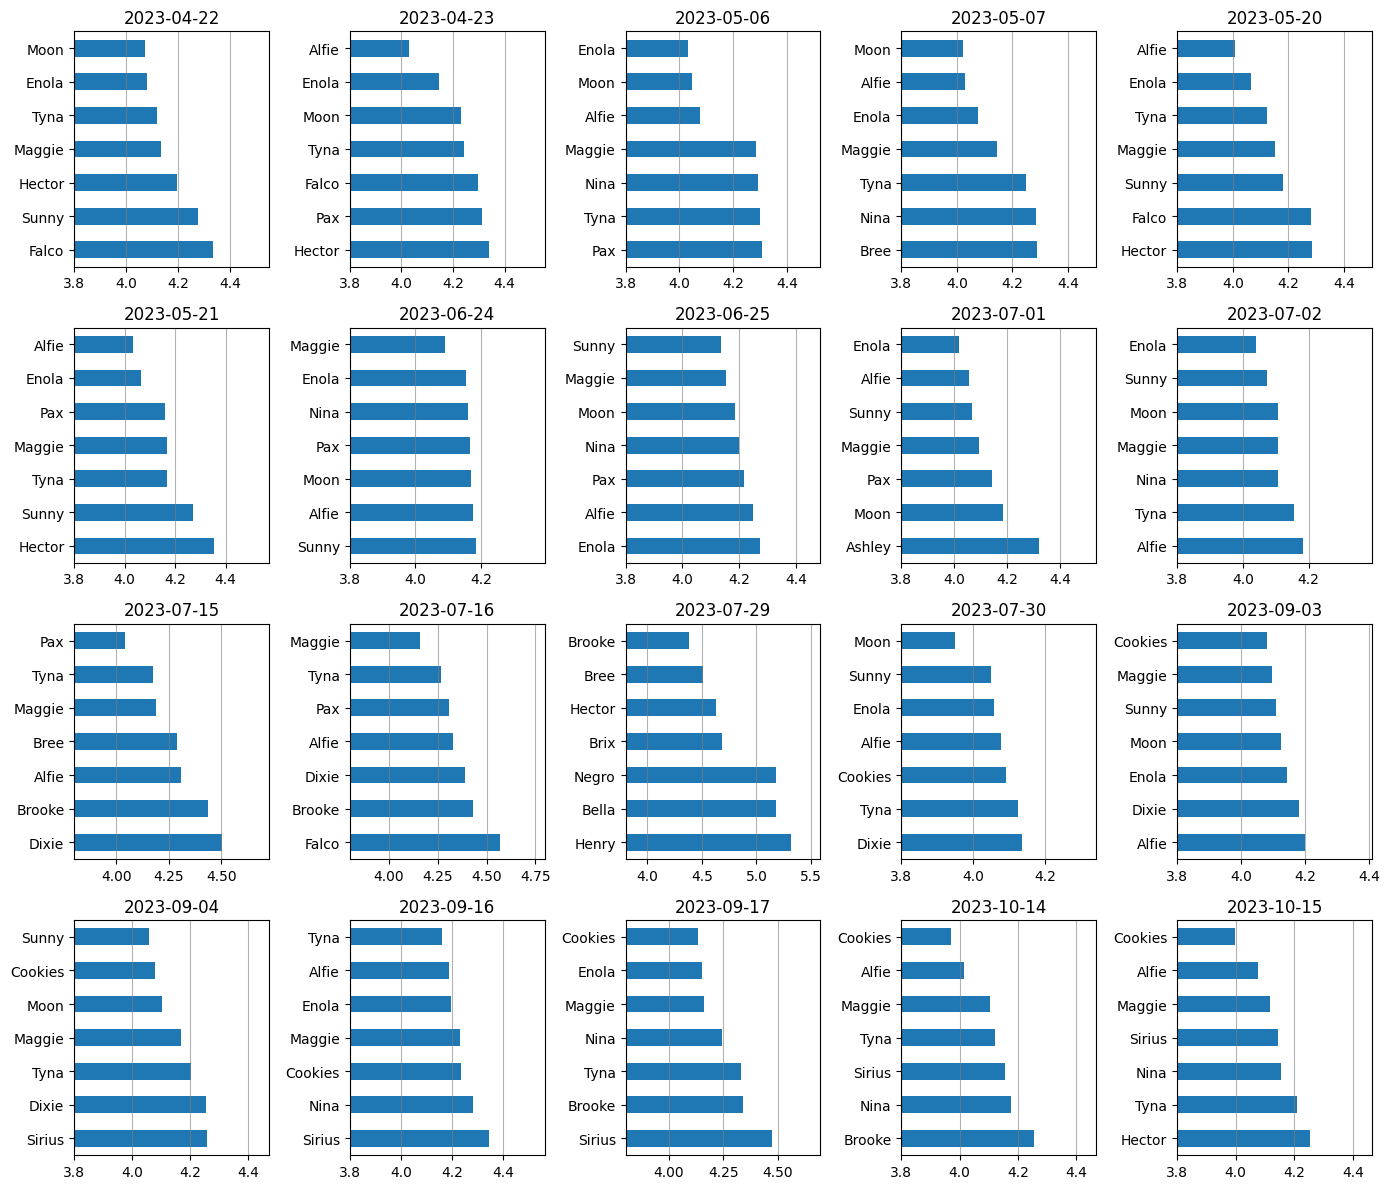

In [96]:
fig, axs = plt.subplots(4, 5, figsize=(14, 12))

for i, day in enumerate(days):
    ax = axs[i//5, i%5]
    best_overall(df_runs_all, day).sort_values(ascending=False).plot(kind='barh', ax=ax)
    ax.set_title(day)
    ax.set_ylabel('')
    ax.set_xlim(3.8,)
    ax.grid(axis='x', color='gray', alpha=0.6)

plt.tight_layout()
plt.show()

## Fastest dogs per day

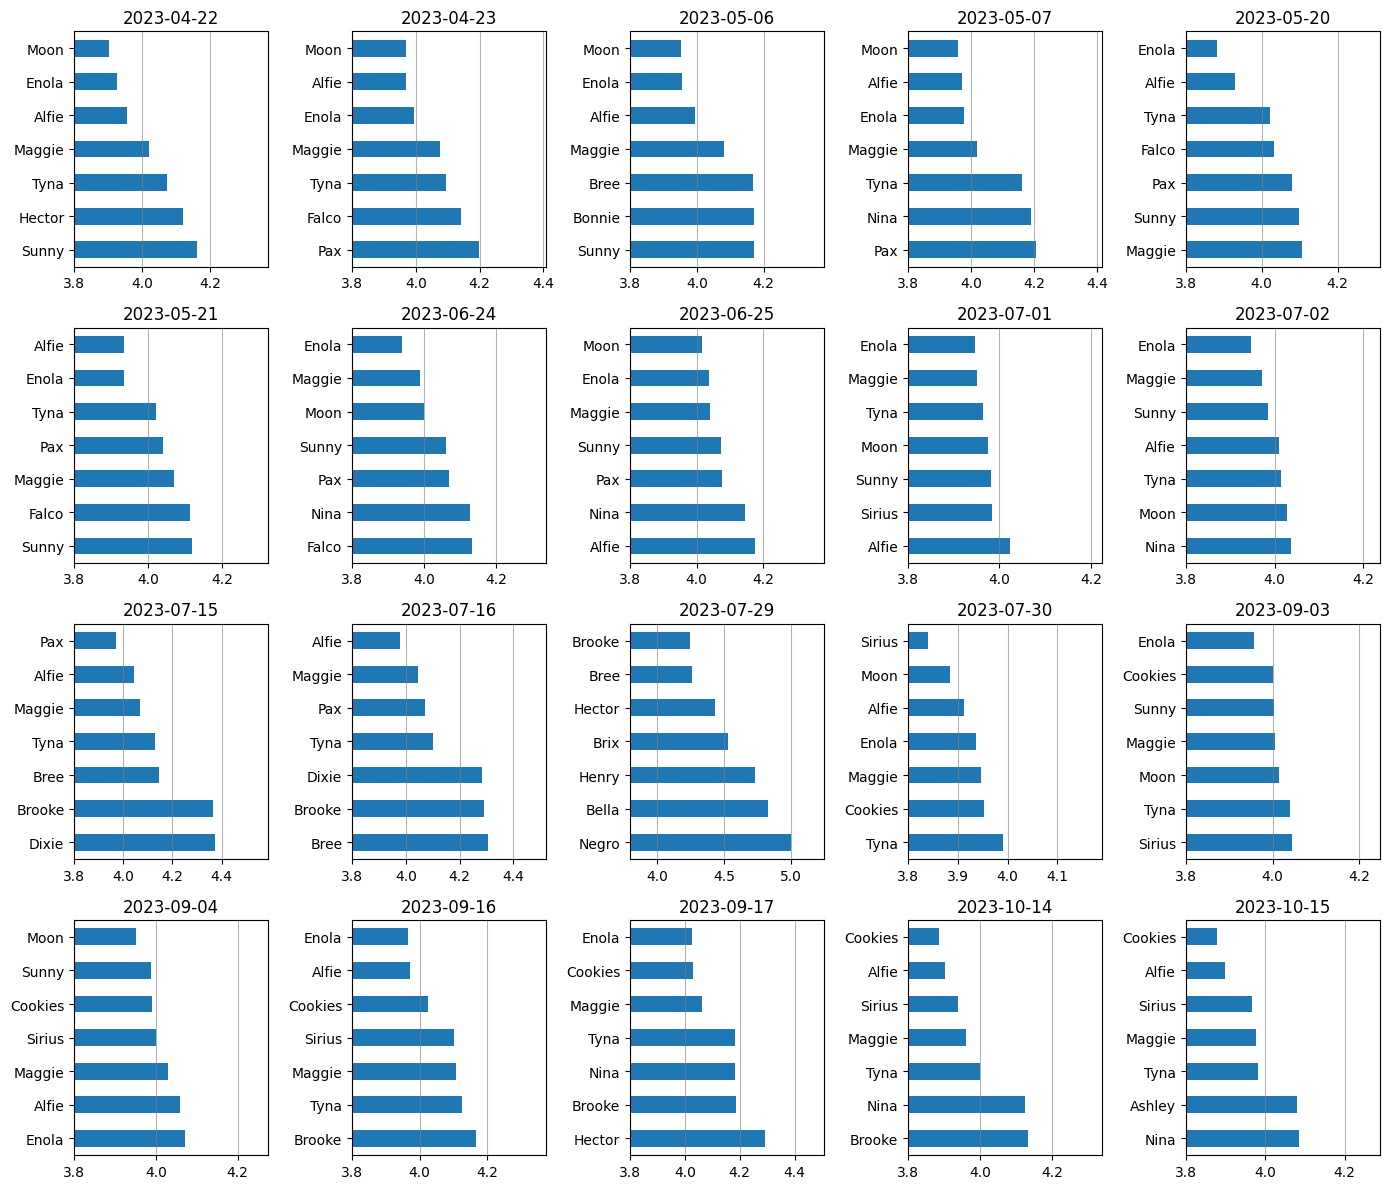

In [85]:
fig, axs = plt.subplots(4, 5, figsize=(14, 12))

for i, day in enumerate(days):
    ax = axs[i//5, i%5]
    fastest_runers(df_runs_all, day).sort_values(ascending=False).plot(kind='barh', ax=ax)
    ax.set_title(day)
    ax.set_ylabel('')
    ax.set_xlim(3.8,)
    ax.grid(axis='x', color='gray', alpha=0.6)

plt.tight_layout()
plt.show()

## Best starters per day

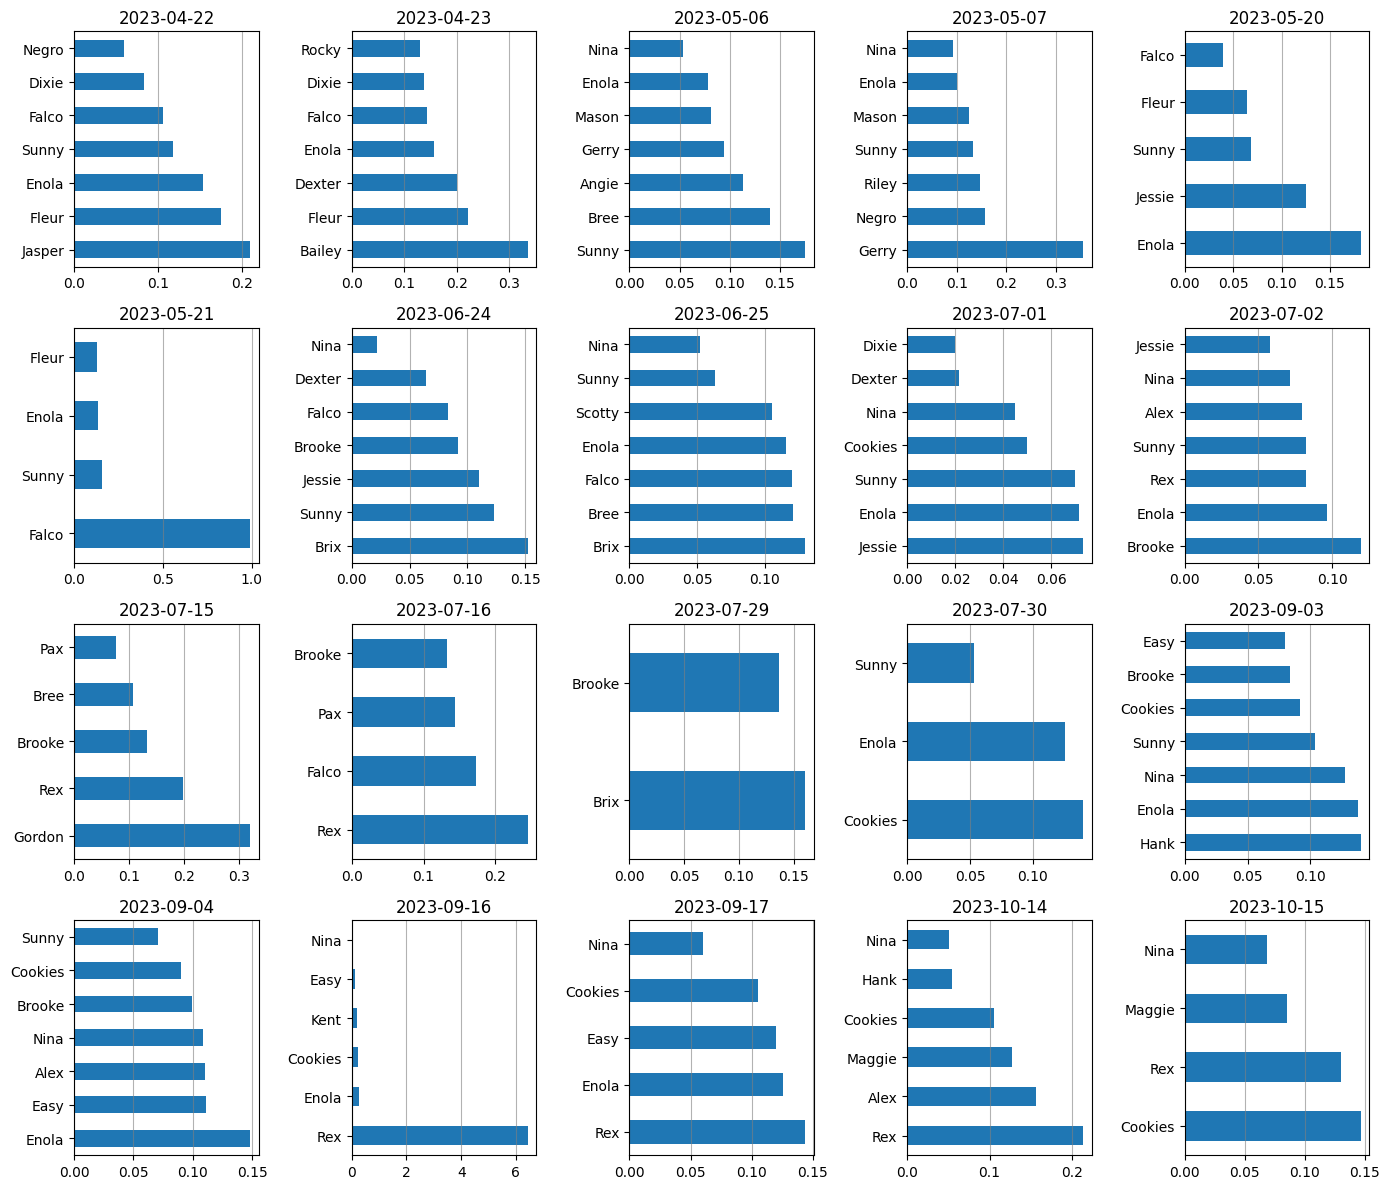

In [89]:
fig, axs = plt.subplots(4, 5, figsize=(14, 12))

for i, day in enumerate(days):
    ax = axs[i//5, i%5]
    fastest_starters(df_run1, day).sort_values(ascending=False).plot(kind='barh', ax=ax)
    ax.set_title(day)
    ax.set_ylabel('')
    ax.grid(axis='x', color='gray', alpha=0.6)

plt.tight_layout()
plt.show()

## Best changers per day

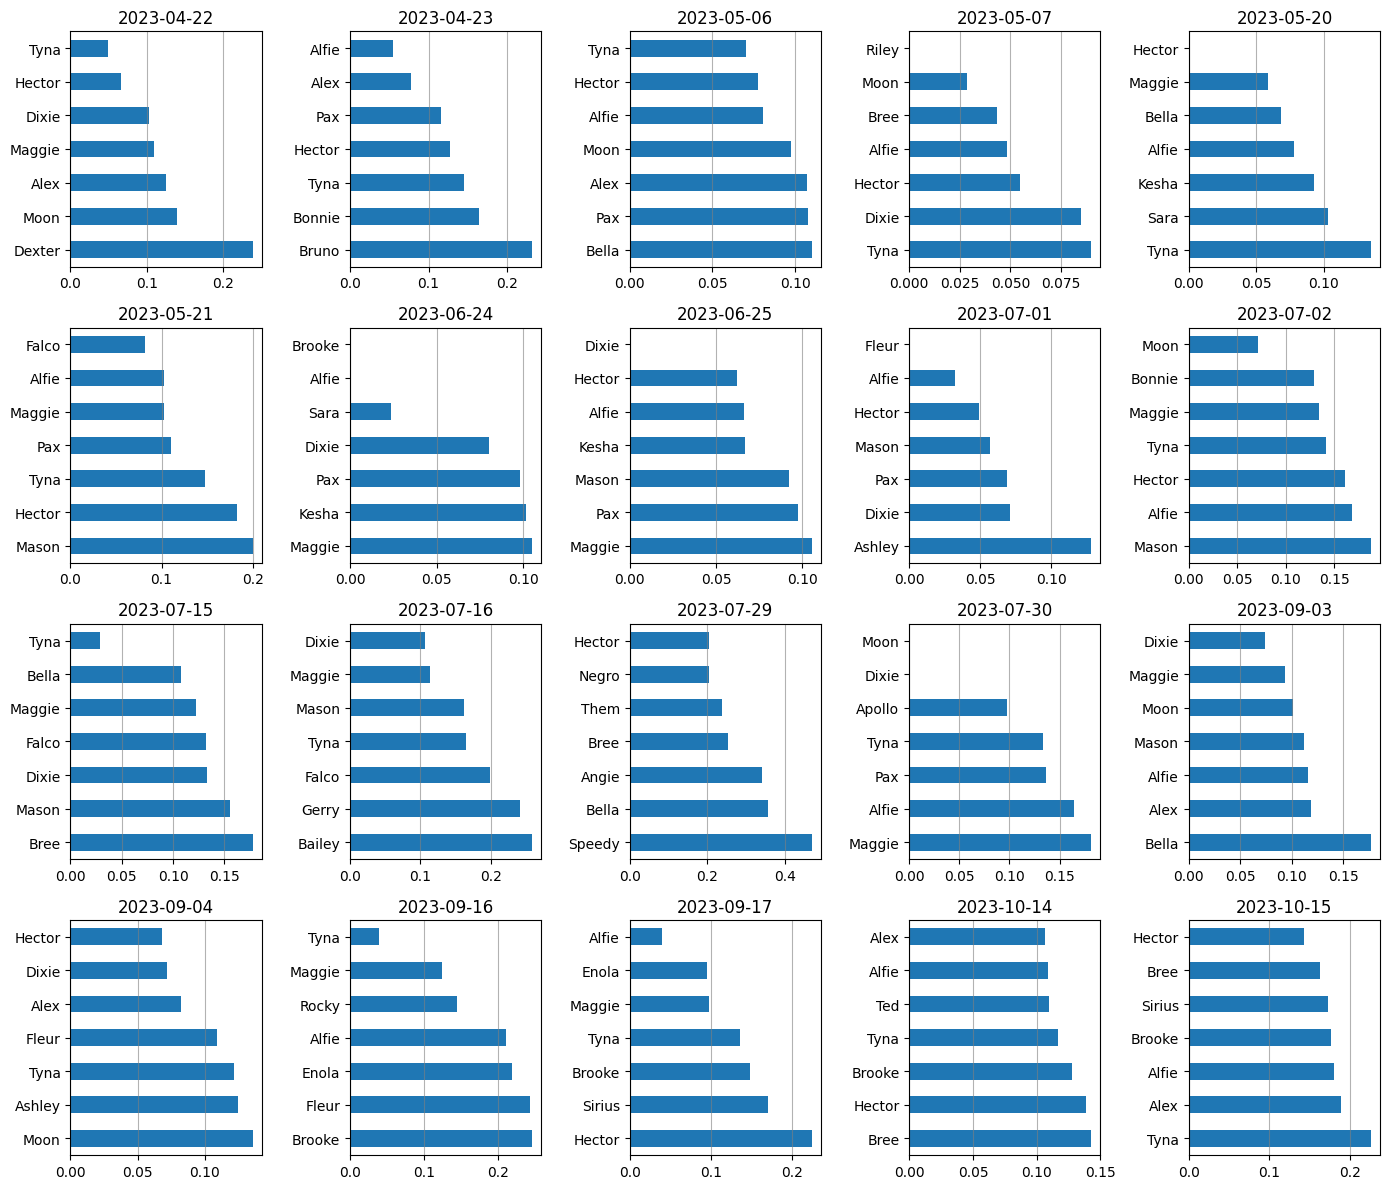

In [90]:
fig, axs = plt.subplots(4, 5, figsize=(14, 12))

for i, day in enumerate(days):
    ax = axs[i//5, i%5]
    fastest_starters(df_runs_234, day).sort_values(ascending=False).plot(kind='barh', ax=ax)
    ax.set_title(day)
    ax.set_ylabel('')
    ax.grid(axis='x', color='gray', alpha=0.6)

plt.tight_layout()
plt.show()

## Wrong start/change ratios per day

Showing the top seven dogs with the lowest wrong start / change ratios in percentage 

Only dogs with at least 5 runs are taken into account

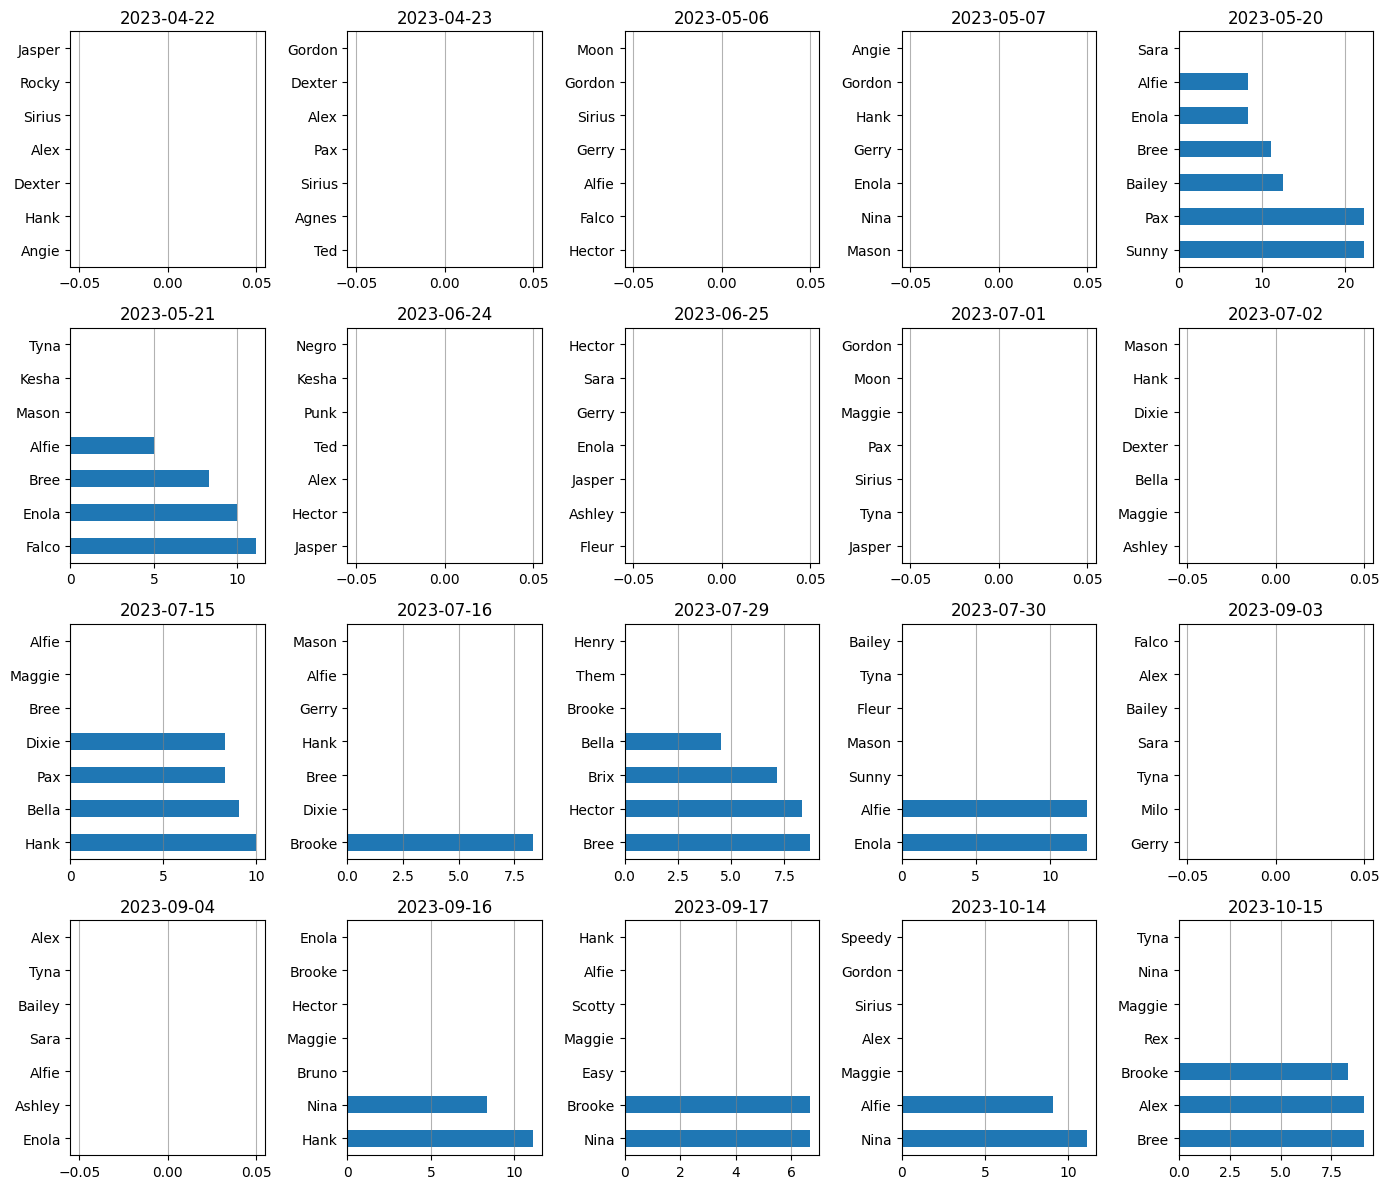

In [119]:
fig, axs = plt.subplots(4, 5, figsize=(14, 12))

for i, day in enumerate(days):
    ax = axs[i//5, i%5]
    good_starters(df_runs_all, day).wrong_ratio.sort_values(ascending=False).plot(kind='barh', ax=ax)
    ax.set_title(day)
    ax.set_ylabel('')
    ax.grid(axis='x', color='gray', alpha=0.6)

plt.tight_layout()
plt.show()

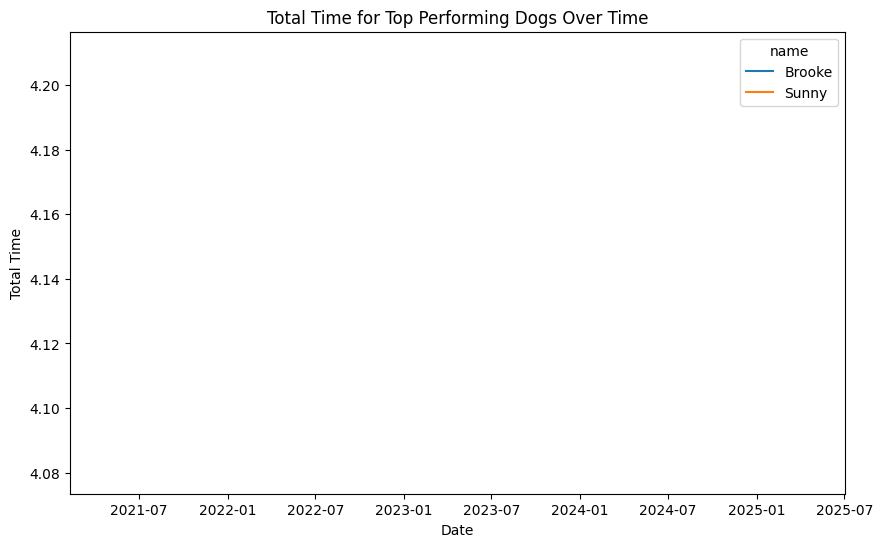

In [122]:
import matplotlib.pyplot as plt

# Filter DataFrame for top performing dogs
df_top_dogs = df_runs_all[df_runs_all.name.isin(top_2_any_day)][:2]

# Group by date and dog, calculate total time
df_top_dogs_total_time = df_top_dogs.groupby([df_top_dogs.when.dt.date, 'name']).time.sum().reset_index()

# Pivot DataFrame for plotting
df_top_dogs_total_time_pivot = df_top_dogs_total_time.pivot(index='when', columns='name', values='time')

# Plot total time for each dog over time
df_top_dogs_total_time_pivot.plot(kind='line', figsize=(10, 6))
plt.title('Total Time for Top Performing Dogs Over Time')
plt.xlabel('Date')
plt.ylabel('Total Time')
plt.show()